In [1]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify as sq
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read RFM_Final dataset
df = pd.read_csv('./datasets/1_SEGMENTATION/RFM_Final.csv')
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,POINTS_SPENT,loyalty_score,MODE_REGIONAL_CODE,OUTLET_ID,CATEGORY_ID,Percentage_SPECIAL,...,MODE_ORIGIN,MODE_PAYMENT_METHOD,MODE_TRANSACTION_HOUR,LONGEVITY,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,AA00312188,25,102,1040,8760,1,11,64,10,0.0,...,3,0,14,4709,2,3,4,234,9,Gold
1,AA00312390,2,58,687,2240,1,42,91,3,0.0,...,3,0,16,3759,4,2,3,423,9,Gold
2,AA00325975,2,205,1386,80675,1,11,7,1,0.0,...,3,3,11,5233,4,4,4,444,12,Gold
3,AA00336843,15,69,498,24255,1,11,6,3,0.0,...,3,0,13,1793,2,3,2,232,7,Silver
4,AA00339761,24,59,574,4030,1,6,7,10,0.0,...,3,0,17,5481,2,2,3,223,7,Silver


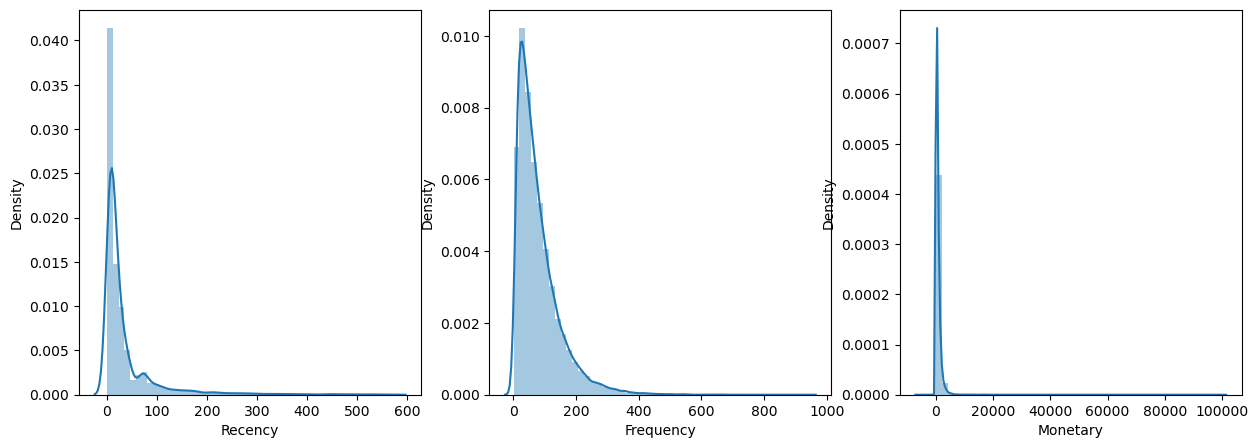

In [5]:
# Checking Skewness of the data
plt.figure(figsize=(15,5))

# Plotting the distribution of Recency
plt.subplot(1,3,1)
sns.distplot(df['Recency'])

# Plotting the distribution of Frequency
plt.subplot(1,3,2)
sns.distplot(df['Frequency'])

# Plotting the distribution of Monetary
plt.subplot(1,3,3)
sns.distplot(df['Monetary'])

plt.show()

- The data from `recency`, `frequency` and `monetary` are all skewed heavily to the left.
- The skeweness must be eliminated before proceeding

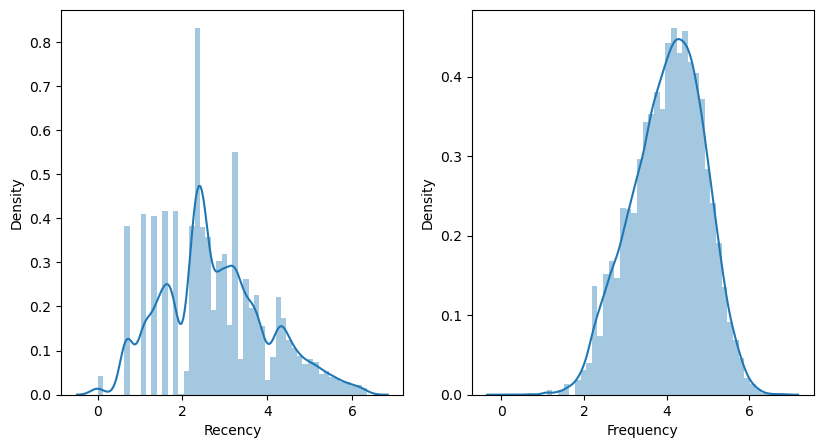

In [10]:
# Removal of skewness
recency_log = np.log(df['Recency'])
frequency_log = np.log(df['Frequency'])
df['Monetary'] = df['Monetary'].astype(int)
monetary_log = np.log(df['Monetary'])

plt.figure(figsize=(15,5))

# Plotting the distribution of Recency
plt.subplot(1,3,1)
sns.distplot(recency_log)

# Plotting the distribution of Frequency
plt.subplot(1,3,2)
sns.distplot(frequency_log)

plt.show()

In [14]:
scaler_rfm = StandardScaler()
scaler_rfm.fit(df[['Recency', 'Frequency', 'Monetary']])

# Standardizing the data
rfm_standardized = scaler_rfm.transform(df[['Recency', 'Frequency', 'Monetary']])

print('mean:', rfm_standardized.mean(axis=0).round(2))
print('std:', rfm_standardized.std(axis=0).round(2))

mean: [ 0.  0. -0.]
std: [1. 1. 1.]


In [52]:
# Create a copy dataset without the CUSTOMER_ID, Segment and Score_Card columns
df_copy = df.drop(columns=['CUSTOMER_ID', 'General_Segment', 'R', 'F', 'M', 'RFM_Segment', 'RFM_Score', 'MODE_REGIONAL_CODE', 'OUTLET_ID', 'Recency', 'Frequency', 'Monetary', 'CATEGORY_ID'])
df_copy.head()

,POINTS_SPENT,loyalty_score,Percentage_SPECIAL,SPECIAL,Mean_SPECIAL,MODE_ORIGIN,MODE_PAYMENT_METHOD,MODE_TRANSACTION_HOUR,MODE_WEEKDAY,LONGEVITY
0,8760,1,0.0,0,0,3,0,14,3,5195
1,2240,1,0.0,0,0,3,0,16,5,4026
2,80675,1,0.0,0,0,3,3,11,5,5500
3,24255,1,0.0,0,0,3,0,13,3,2146
4,4030,1,0.0,0,0,3,0,17,4,5826


In [159]:
# Create CLV column as Customer Lifetime Value
df_CLV = df[['CUSTOMER_ID', 'Recency', 'Frequency', 'Monetary']]
# T - Average number of transactions per month for each customer
# Calculate the average number of transactions per month for each customer
df_CLV['T'] =df_CLV['Frequency'] /df_CLV['Recency']
df_CLV['T'] = df_CLV['T'].fillna(0)
df_CLV['T'] = df_CLV['T'].replace([np.inf, -np.inf], 0)

# AOV - Average Order Value
# Calculate the average order value for each customer
df_CLV['AOV'] = df_CLV['Monetary'] / df_CLV['Frequency']
df_CLV['AOV'] = df_CLV['AOV'].fillna(0)
df_CLV['AOV'] = df_CLV['AOV'].replace([np.inf, -np.inf], 0)

# AGM - Average Gross Margin
# Calculate the average gross margin for each customer
df_CLV['AGM'] = df_CLV['Monetary'] * 0.1
df_CLV['AGM'] = df_CLV['AGM'].fillna(0)
df_CLV['AGM'] = df_CLV['AGM'].replace([np.inf, -np.inf], 0)

# ALT - Average Customer Lifespan in Months
# Calculate the average customer lifespan in months
df_CLV['ALT'] = 1 / df_CLV['T']
df_CLV['ALT'] = df_CLV['ALT'].fillna(0)
df_CLV['ALT'] = df_CLV['ALT'].replace([np.inf, -np.inf], 0)


# NuCL - Number of Clients during the period
# Calculate the number of clients during the period
df_CLV['NuCL'] = df_CLV['CUSTOMER_ID'].count()

# CLV = (T * AOV * AGM * ALT)/NuCL
df_CLV['CLV'] = (df_CLV['T'] * df_CLV['AOV'] * df_CLV['AGM'] * df_CLV['ALT']) / df_CLV['NuCL']

df['CLV'] = df_CLV['CLV']
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,POINTS_SPENT,loyalty_score,MODE_REGIONAL_CODE,OUTLET_ID,CATEGORY_ID,Percentage_SPECIAL,...,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score,Segment,Score_Card,Cluster,DBSCAN,CLV
0,AA00312188,24,102,1040,8760,1,11,64,10,0.0,...,2,3,4,234,9,At risk,Silver,1,0,0.041217
1,AA00312390,1,58,687,2240,1,42,91,3,0.0,...,4,2,3,423,9,Potential loyalists,Silver,1,0,0.031630
2,AA00325975,1,205,1386,80675,1,11,7,1,0.0,...,4,4,4,444,12,Loyal customers,Platinum,1,0,0.036424
3,AA00336843,14,69,498,24255,1,11,6,3,0.0,...,2,3,2,232,7,At risk,Bronze,4,0,0.013971
4,AA00339761,23,59,574,4030,1,6,7,10,0.0,...,2,2,3,223,7,Hibernating,Bronze,1,0,0.021706


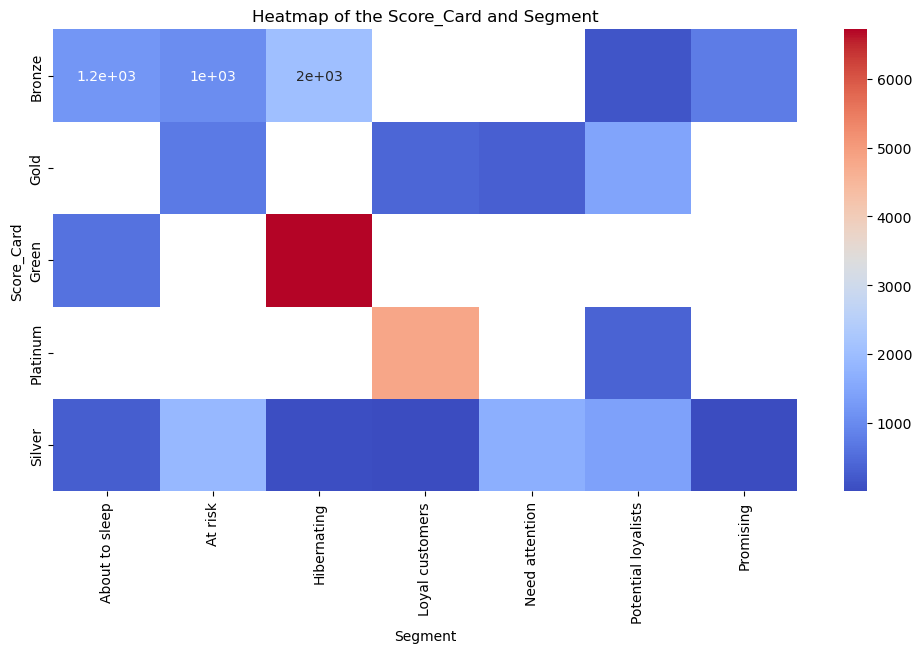

In [46]:
# Plot a heatmap of the Score_Card, Segment and Customer_ID columns
plt.figure(figsize=(12, 6))
sns.heatmap(df.groupby(['Score_Card', 'Segment']).size().unstack(), annot=True, cmap='coolwarm')
plt.title('Heatmap of the Score_Card and Segment')
plt.show()

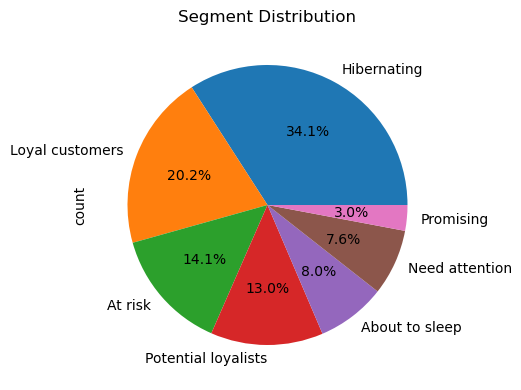

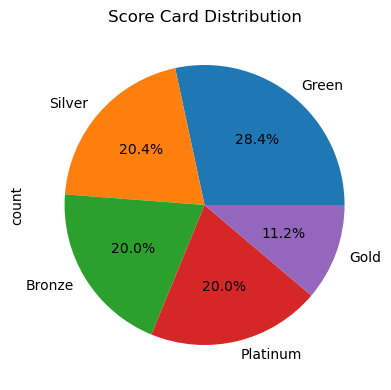

In [161]:
# Plot a pie chart to see the distribution of the segments
# Label each segment with the percentage of the total
plt.figure(figsize=(10, 10))
plt.subplot(221)
df['Segment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Segment Distribution')
plt.show()

# Plot a pie chart to see the distribution of the score cards
# Label each score card with the percentage of the total
plt.figure(figsize=(10, 10))
plt.subplot(222)
df['Score_Card'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Score Card Distribution')
plt.show()


In [162]:
df.columns

Index(['CUSTOMER_ID', 'Recency', 'Frequency', 'Monetary', 'POINTS_SPENT',
       'loyalty_score', 'MODE_REGIONAL_CODE', 'OUTLET_ID', 'CATEGORY_ID',
       'Percentage_SPECIAL', 'SPECIAL', 'Mean_SPECIAL', 'MODE_ORIGIN',
       'MODE_PAYMENT_METHOD', 'MODE_TRANSACTION_HOUR', 'MODE_WEEKDAY',
       'LONGEVITY', 'R_quartile', 'F_quartile', 'M_quartile', 'RFM_Segment',
       'RFM_Score', 'Segment', 'Score_Card', 'Cluster', 'DBSCAN', 'CLV'],
      dtype='object')

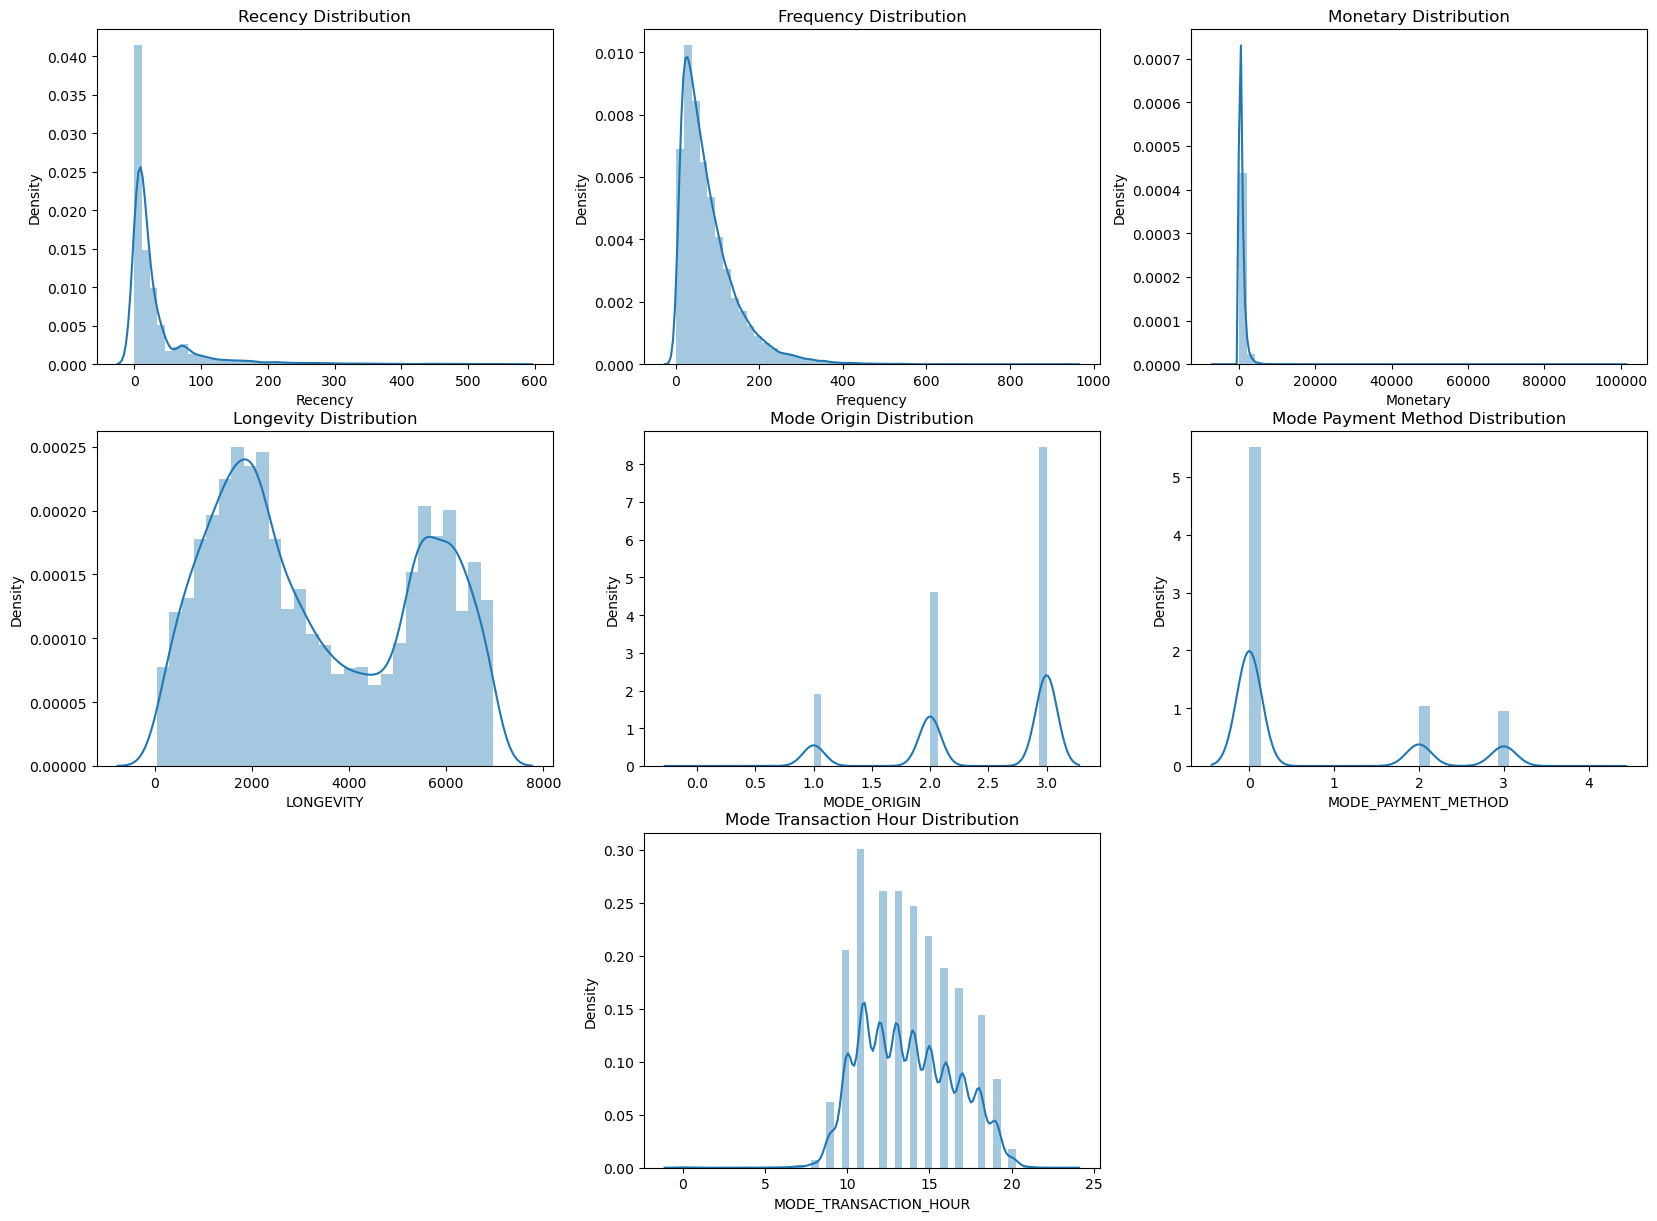

In [163]:
# Plot a combined displot of: Recency, Frequency, Monetary, LONGEVITY, MODE_ORIGIN, MODE_PAYMENT_METHOD, MODE_TRANSACTION_HOUR
plt.figure(figsize=(20, 20))

# Recency
plt.subplot(4, 3, 1)
sns.distplot(df['Recency'])
plt.title('Recency Distribution')

# Frequency
plt.subplot(4, 3, 2)
sns.distplot(df['Frequency'])
plt.title('Frequency Distribution')

# Monetary
plt.subplot(4, 3, 3)
sns.distplot(df['Monetary'])
plt.title('Monetary Distribution')

# Longevity
plt.subplot(4, 3, 4)
sns.distplot(df['LONGEVITY'])
plt.title('Longevity Distribution')

# Mode Origin
plt.subplot(4, 3, 5)
sns.distplot(df['MODE_ORIGIN'])
plt.title('Mode Origin Distribution')

# Mode Payment Method
plt.subplot(4, 3, 6)
sns.distplot(df['MODE_PAYMENT_METHOD'])
plt.title('Mode Payment Method Distribution')

# Mode Transaction Hour
plt.subplot(4, 3, 8)
sns.distplot(df['MODE_TRANSACTION_HOUR'])
plt.title('Mode Transaction Hour Distribution')

plt.show()

### From this distributions we can draw the following conclusions:
- For `payment_method` majority of the customers pay via cash then credit card and debit card.
- For `transaction_hour` the most transactions occur from mid-morning to early afternoon.
- While the `recency`, `frequency` and `monetary` plots show that majority of the customers aren't shopping in close intervals, nor are majority shopping frequently and also that majority of the customers aren't spending on high value transactions.
- Likewise `Longevity` follows a similar distribution with most customers having joined early and the next large chunk coming more recently to the end of the data collection period

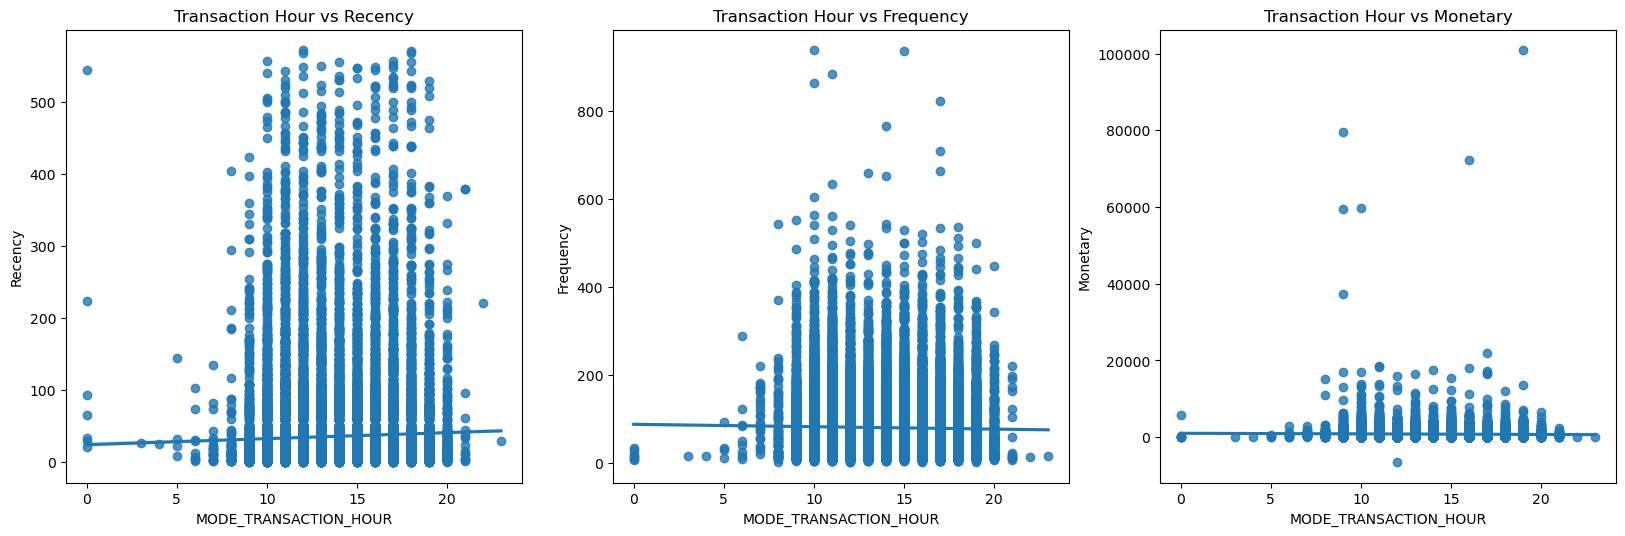

In [164]:
plt.figure(figsize=(20, 20))

# Transaction Hour vs Recency
plt.subplot(3, 3, 1)
sns.regplot(x='MODE_TRANSACTION_HOUR', y='Recency', data=df)
plt.title('Transaction Hour vs Recency')

# Transaction Hour vs Frequency
plt.subplot(3, 3, 2)
sns.regplot(x='MODE_TRANSACTION_HOUR', y='Frequency', data=df)
plt.title('Transaction Hour vs Frequency')

# Transaction Hour vs Monetary
plt.subplot(3, 3, 3)
sns.regplot(x='MODE_TRANSACTION_HOUR', y='Monetary', data=df)
plt.title('Transaction Hour vs Monetary')

plt.show()

In [165]:
df_copy.columns

Index(['POINTS_SPENT', 'loyalty_score', 'Percentage_SPECIAL', 'SPECIAL',
       'Mean_SPECIAL', 'MODE_ORIGIN', 'MODE_PAYMENT_METHOD',
       'MODE_TRANSACTION_HOUR', 'MODE_WEEKDAY', 'LONGEVITY'],
      dtype='object')

In [166]:
# Scale the data
scaler = StandardScaler()
# fit the data
df_scaled = scaler.fit(df_copy)
# transform the data
df_scaled = scaler.transform(df_copy)

In [167]:
# Perform Principle Component Analysis (PCA)
pca_obj = PCA()

# Fit the PCA object to the scaled data
pca_obj.fit(df_scaled)
# PCA Features
features = range(pca_obj.n_components_)
# Transform the scaled data
df_pca = pca_obj.transform(df_scaled)

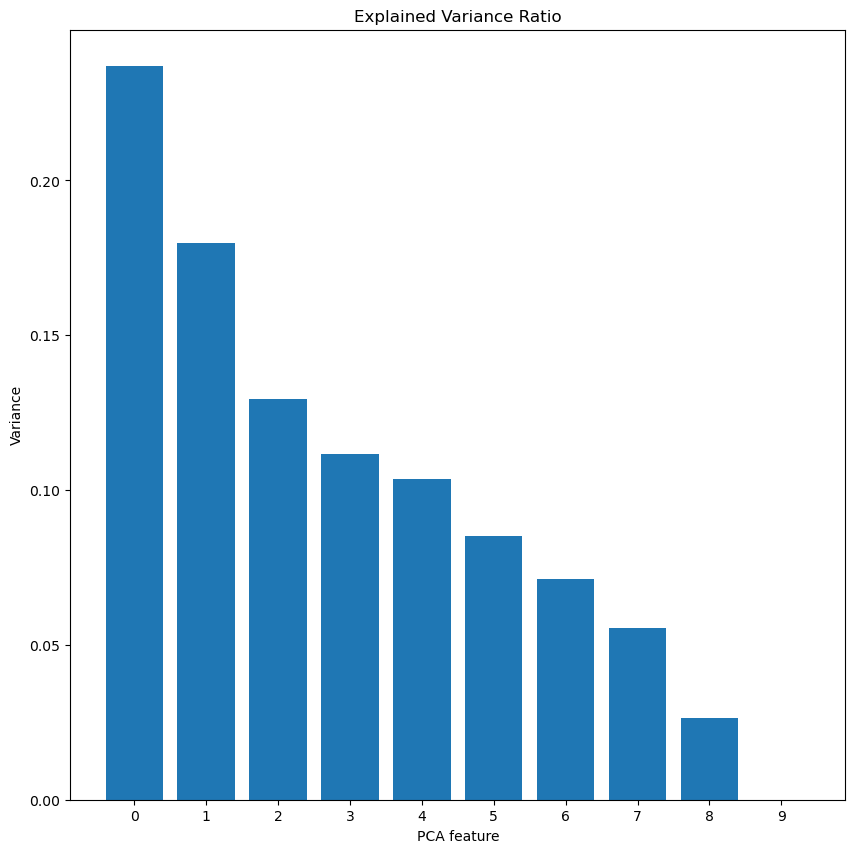

In [168]:
# Plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.bar(features, pca_obj.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title('Explained Variance Ratio')
plt.show()

In [169]:
# Create a new pca object
pca_2 = PCA(n_components=2, svd_solver='full')
# Fit the PCA object to the scaled data
df_pca_2 = pca_2.fit_transform(df_scaled)

Text(0.5, 1.0, 'PCA Components')

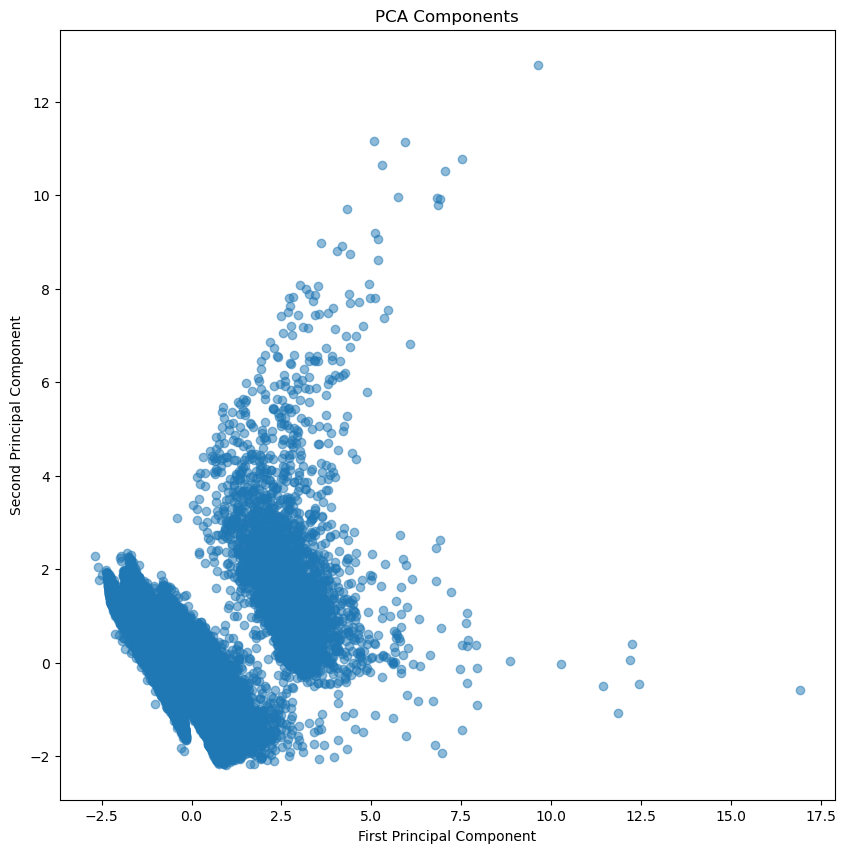

In [170]:
# Plot a scatter plot of the PCA components
plt.figure(figsize=(10, 10))
plt.scatter(df_pca_2[:, 0], df_pca_2[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Components')

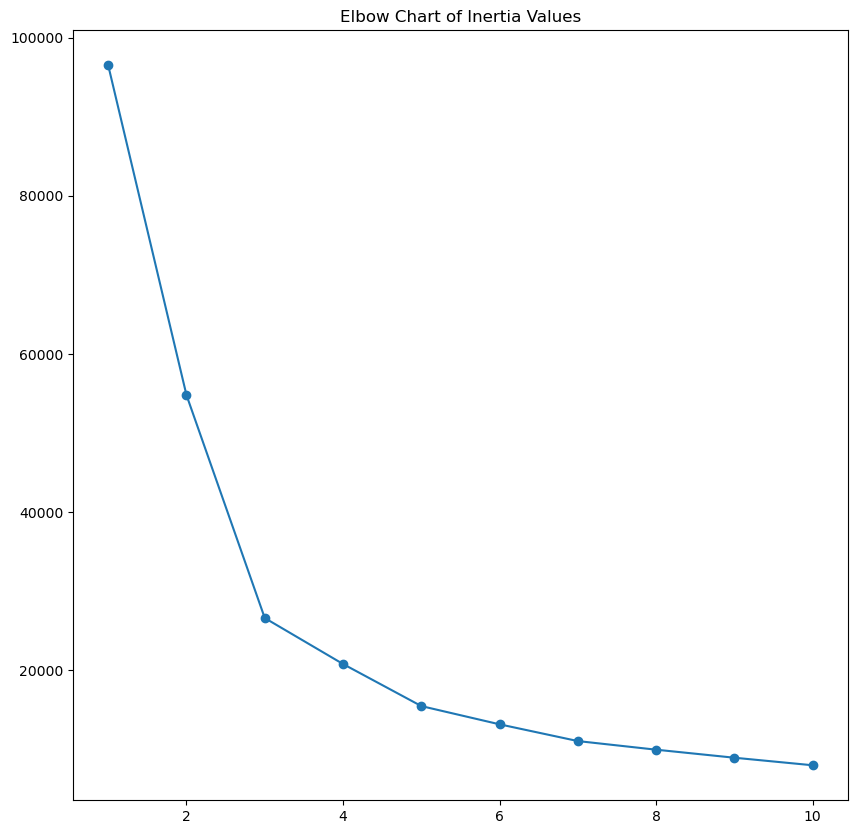

In [171]:
# Application of KMeans
# Create a list to store the inertia values
inertia = []

# Create a range of K values
k_values = range(1, 11)

# Loop through the K values
for k in k_values:
    # Create a KMeans object
    kmeans = KMeans(n_clusters=k, random_state=0)
    # Fit the KMeans object to the PCA data
    kmeans.fit(df_pca_2)
    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(10, 10))
plt.title('Elbow Chart of Inertia Values')
plt.plot(k_values, inertia, marker='o')

In [172]:
# Selection of the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df_pca_2)
df['Cluster'] = kmeans.labels_

In [217]:
# Melt The Data
df_melt = pd.melt(df.copy().reset_index(),
                      id_vars=['CUSTOMER_ID', 'Cluster', 'DBSCAN', 'CLV'],
                      value_vars=['R_quartile','F_quartile','M_quartile'],
                      var_name='Attribute',
                      value_name='Value')
df_melt.head()


,CUSTOMER_ID,Cluster,DBSCAN,CLV,Attribute,Value
0,AA00312188,1,0,0.041217,R_quartile,2
1,AA00312390,1,0,0.031630,R_quartile,4
2,AA00325975,1,0,0.036424,R_quartile,4
3,AA00336843,4,0,0.013971,R_quartile,2
4,AA00339761,1,0,0.021706,R_quartile,2


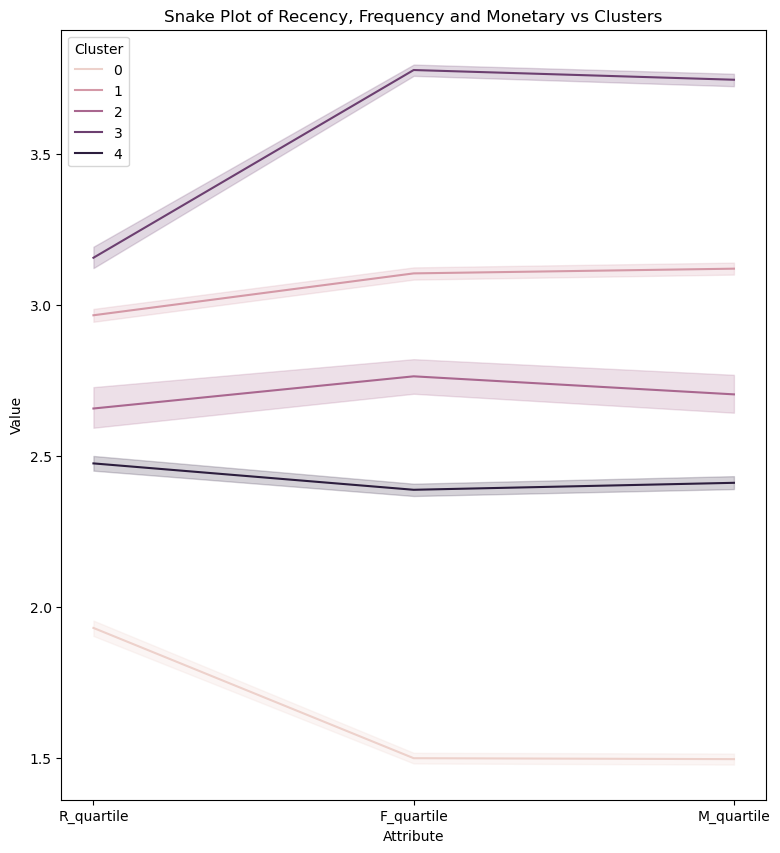

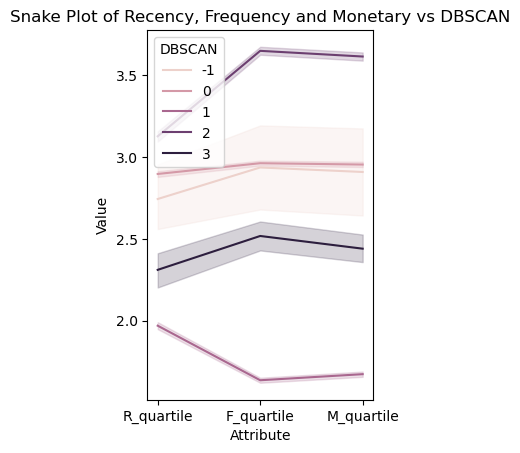

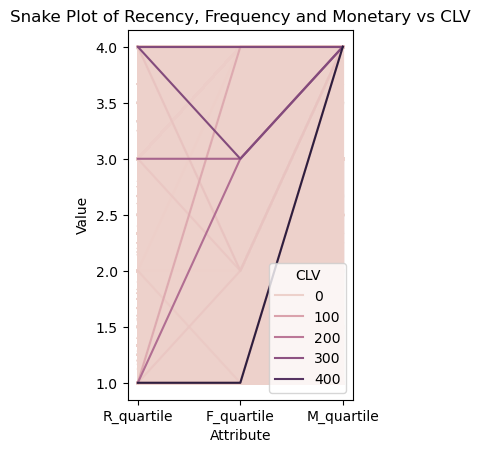

In [222]:
# Plot an overlapping snake plot of the Recency, Frequency and Monetary vs the Clusters
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_melt)
plt.title('Snake Plot of Recency, Frequency and Monetary vs Clusters')
plt.show()

plt.subplot(1, 2, 2)
sns.lineplot(x='Attribute', y='Value', hue='DBSCAN', data=df_melt)
plt.title('Snake Plot of Recency, Frequency and Monetary vs DBSCAN')
plt.show()

plt.subplot(1, 2, 2)
sns.lineplot(x='Attribute', y='Value', hue='CLV', data=df_melt)
plt.title('Snake Plot of Recency, Frequency and Monetary vs CLV')
plt.show()

In [175]:
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,POINTS_SPENT,loyalty_score,MODE_REGIONAL_CODE,OUTLET_ID,CATEGORY_ID,Percentage_SPECIAL,...,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score,Segment,Score_Card,Cluster,DBSCAN,CLV
0,AA00312188,24,102,1040,8760,1,11,64,10,0.0,...,2,3,4,234,9,At risk,Silver,1,0,0.041217
1,AA00312390,1,58,687,2240,1,42,91,3,0.0,...,4,2,3,423,9,Potential loyalists,Silver,1,0,0.031630
2,AA00325975,1,205,1386,80675,1,11,7,1,0.0,...,4,4,4,444,12,Loyal customers,Platinum,1,0,0.036424
3,AA00336843,14,69,498,24255,1,11,6,3,0.0,...,2,3,2,232,7,At risk,Bronze,4,0,0.013971
4,AA00339761,23,59,574,4030,1,6,7,10,0.0,...,2,2,3,223,7,Hibernating,Bronze,1,0,0.021706


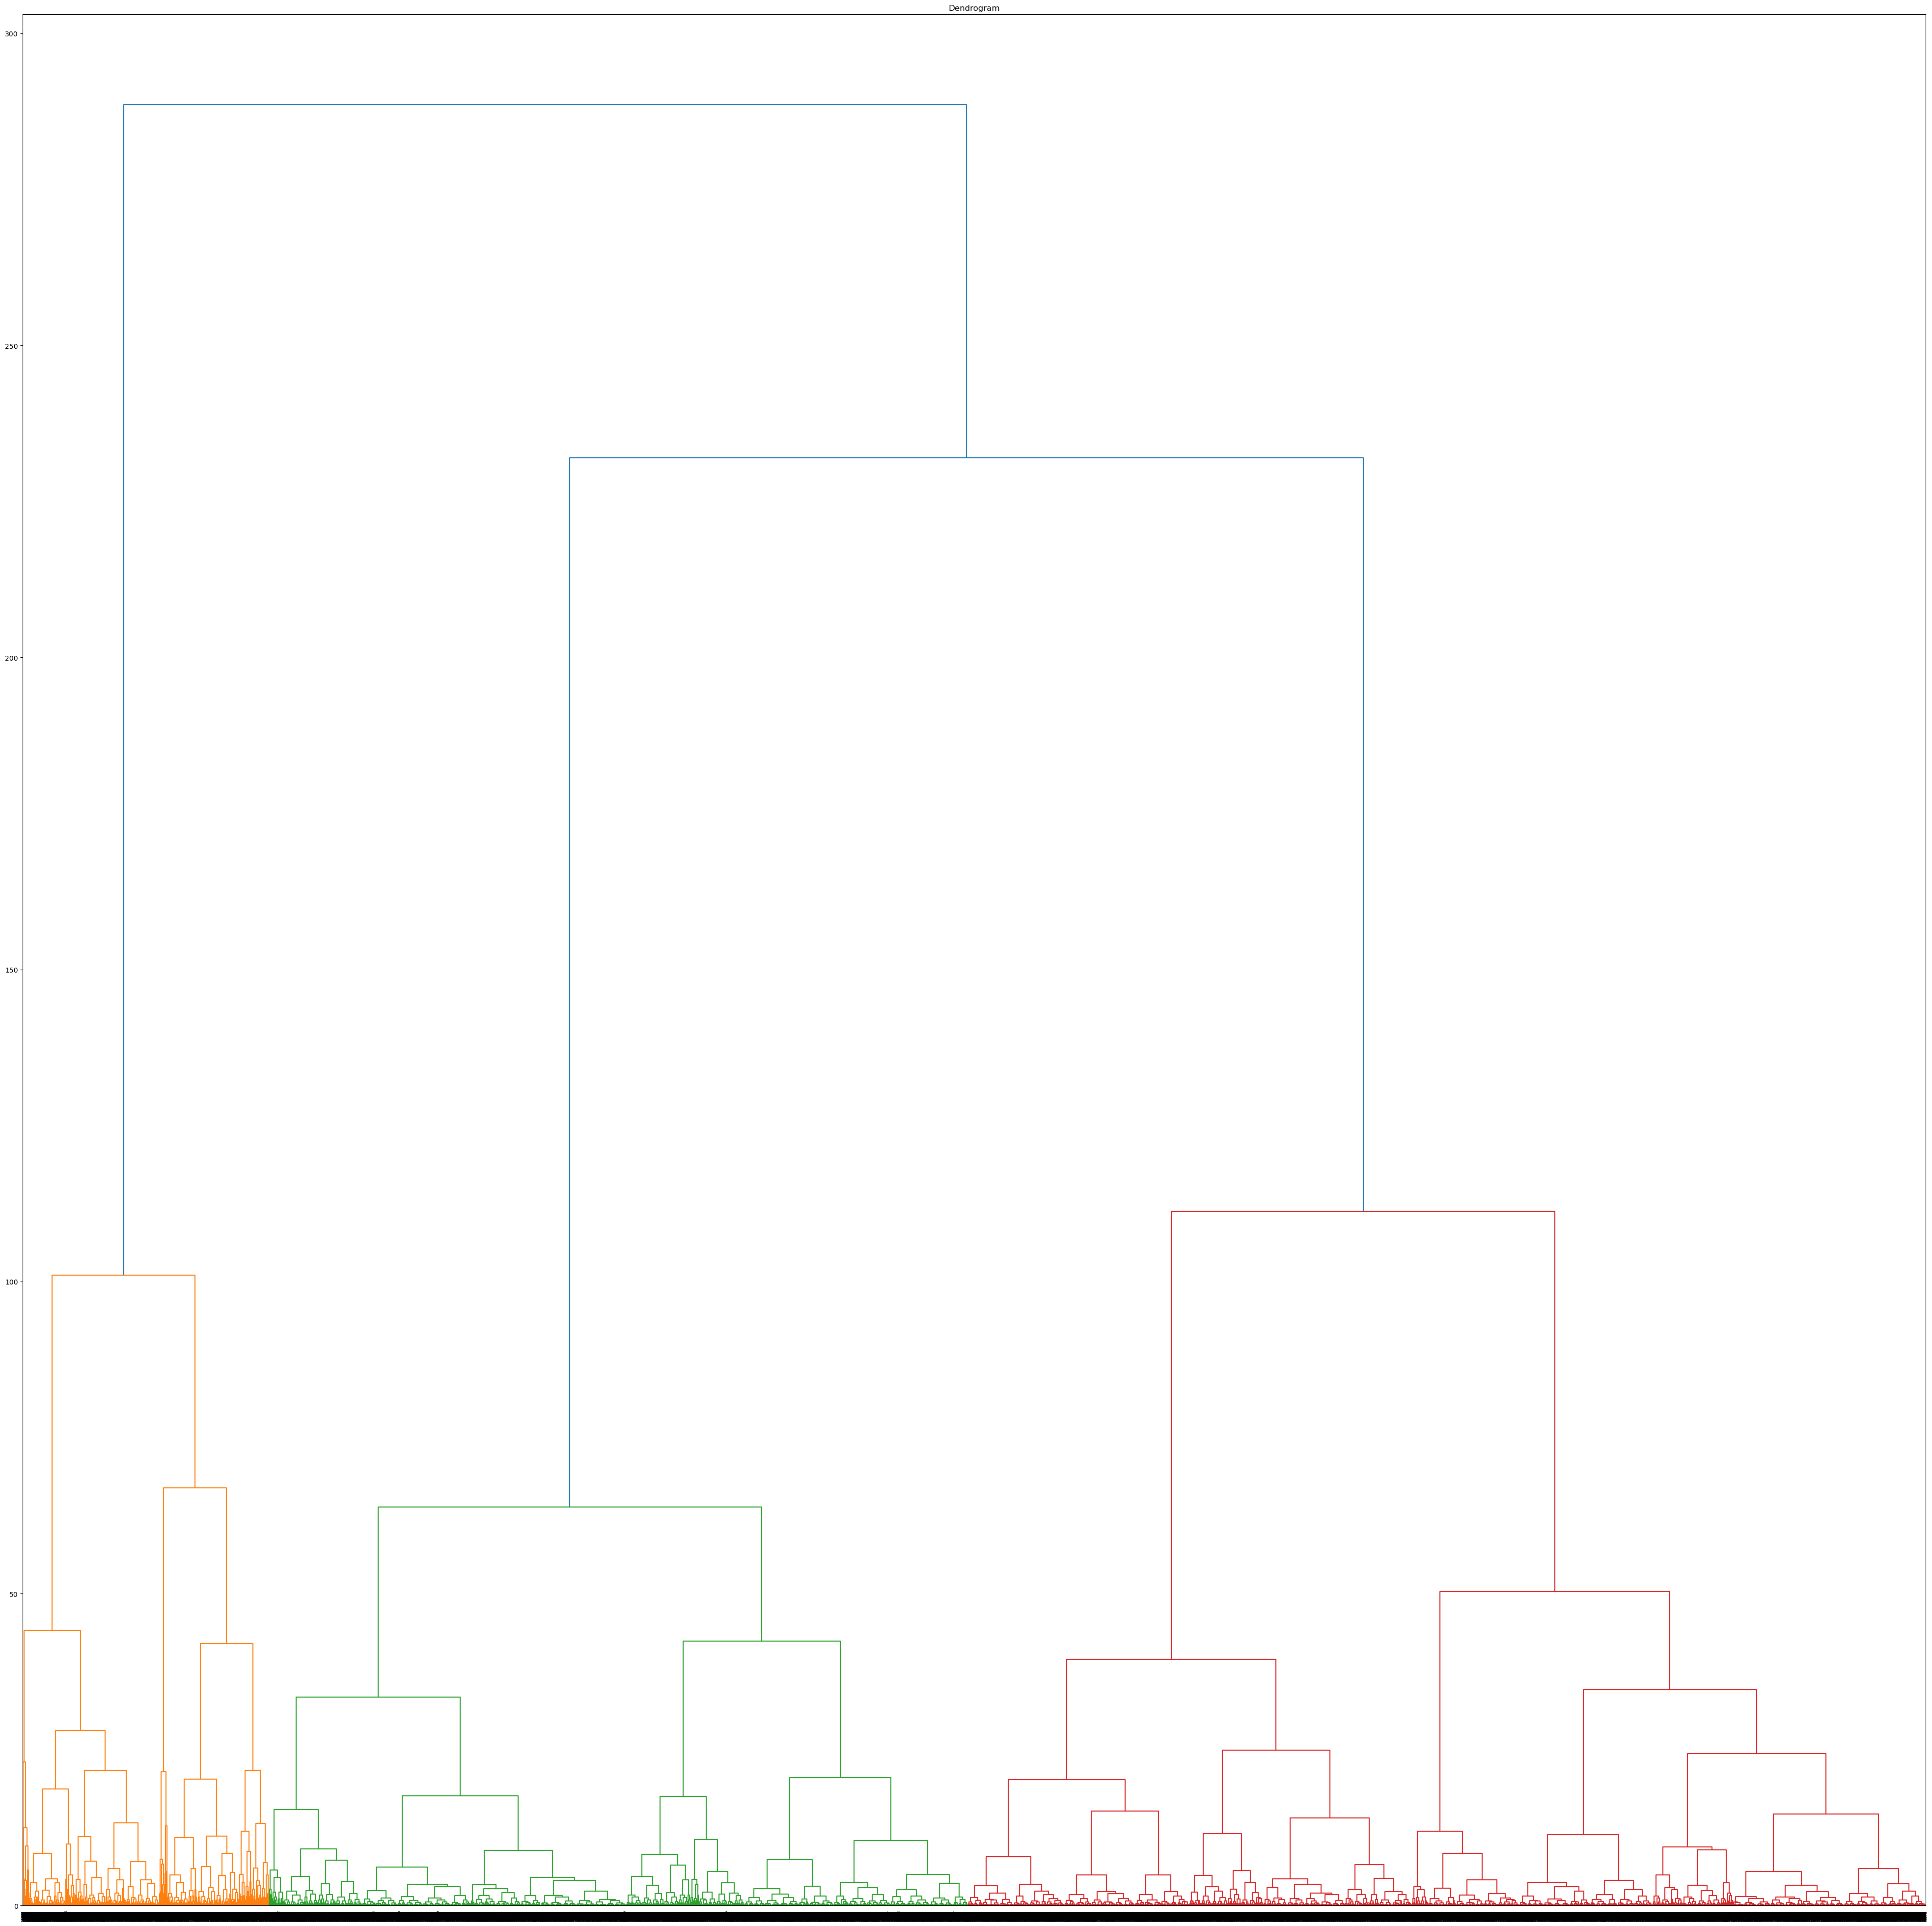

In [152]:
# Create a linkage matrix
linkage_matrix = linkage(df_pca_2, 'ward')

# Plot the dendrogram
plt.figure(figsize=(50, 50))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.show()

In [176]:
# Apply hierarchical clustering
# Create a DBSCAN object
dbscan = DBSCAN(eps=2, min_samples=5)
# Fit the DBSCAN object to the PCA data
df['DBSCAN'] = dbscan.fit_predict(df_scaled)

In [177]:
df.columns

Index(['CUSTOMER_ID', 'Recency', 'Frequency', 'Monetary', 'POINTS_SPENT',
       'loyalty_score', 'MODE_REGIONAL_CODE', 'OUTLET_ID', 'CATEGORY_ID',
       'Percentage_SPECIAL', 'SPECIAL', 'Mean_SPECIAL', 'MODE_ORIGIN',
       'MODE_PAYMENT_METHOD', 'MODE_TRANSACTION_HOUR', 'MODE_WEEKDAY',
       'LONGEVITY', 'R_quartile', 'F_quartile', 'M_quartile', 'RFM_Segment',
       'RFM_Score', 'Segment', 'Score_Card', 'Cluster', 'DBSCAN', 'CLV'],
      dtype='object')

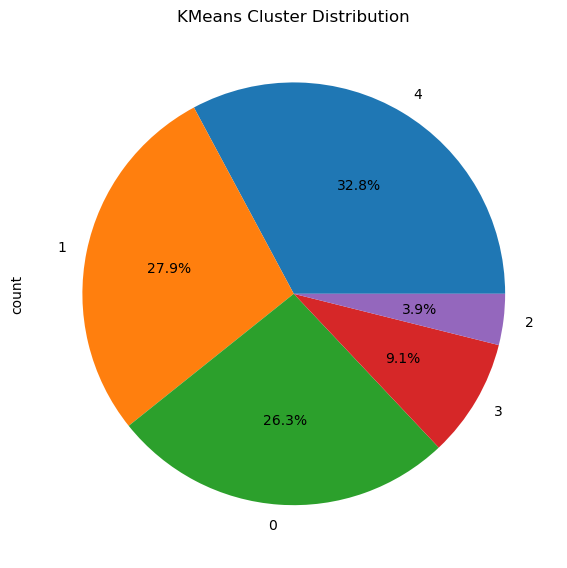

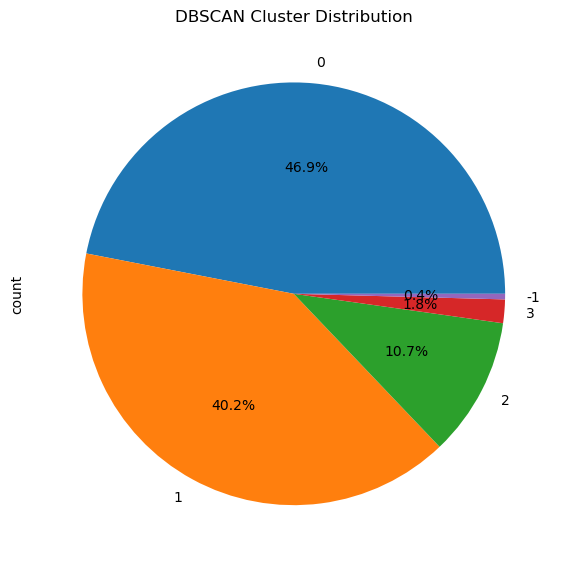

In [178]:
# Plot a pie chart to see the distribution of the clusters
# Label each cluster with the percentage of the total
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
df['Cluster'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('KMeans Cluster Distribution')
plt.show()

# plot a pie chart of DBSCAN
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 2)
df['DBSCAN'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('DBSCAN Cluster Distribution')
plt.show()

Text(0.5, 1.0, 'DBSCAN with PCA Components')

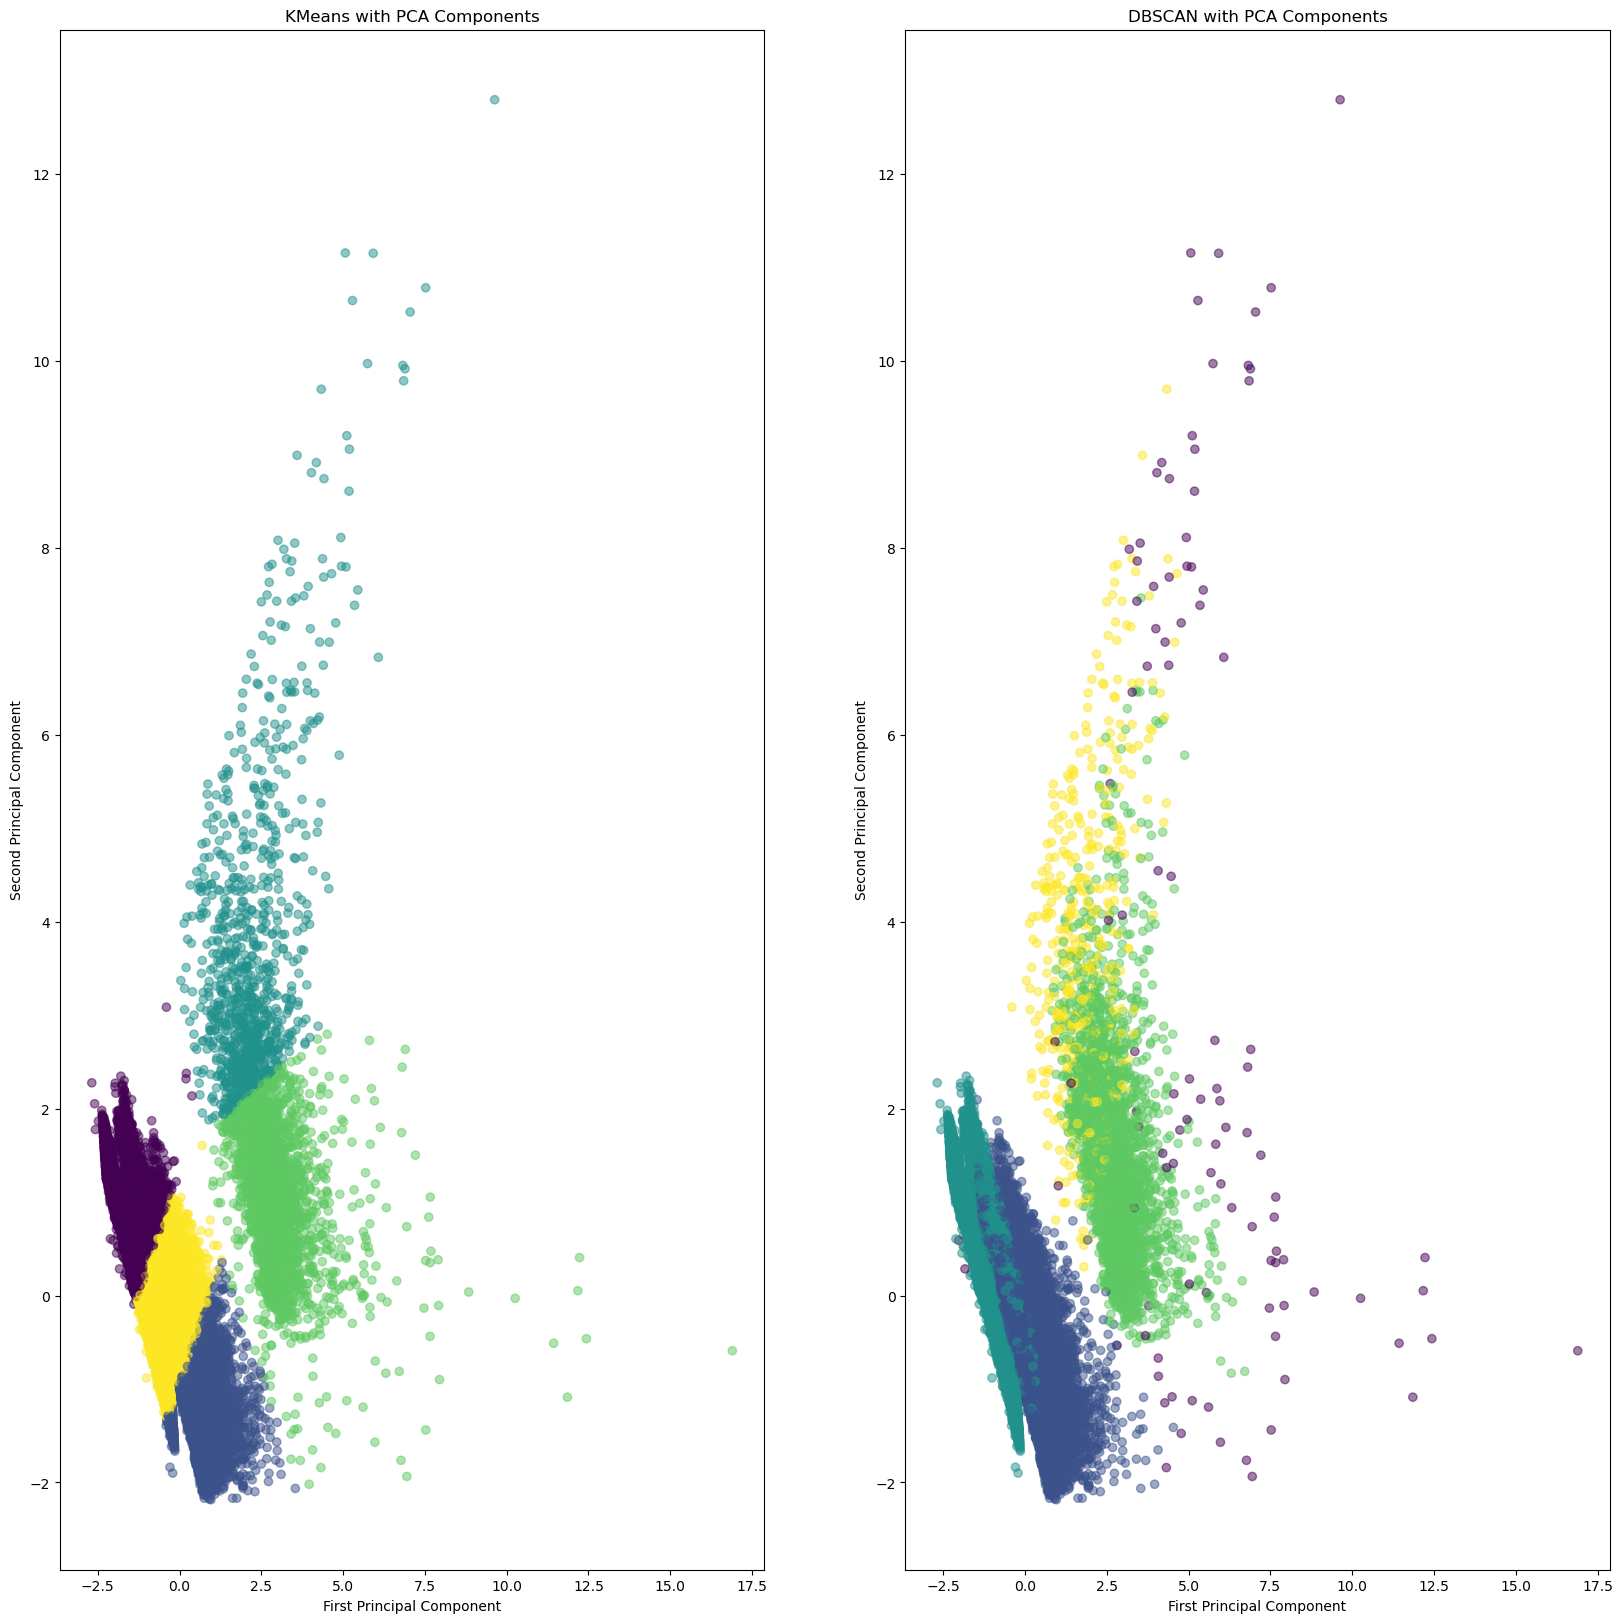

In [216]:
plt.figure(figsize=(20, 20))

kmeans_cluster = df['Cluster'].to_list()
dbscan_cluster = df['DBSCAN'].to_list()

# Plot the KMeans scatter plot of the PCA components
plt.subplot(1, 2, 1)
plt.scatter(df_pca_2[:, 0], df_pca_2[:, 1], c=kmeans_cluster, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('KMeans with PCA Components')

# Plot the DBSCAN scatter plot of the PCA components
plt.subplot(1, 2, 2)
plt.scatter(df_pca_2[:, 0], df_pca_2[:, 1], c=dbscan_cluster, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('DBSCAN with PCA Components')

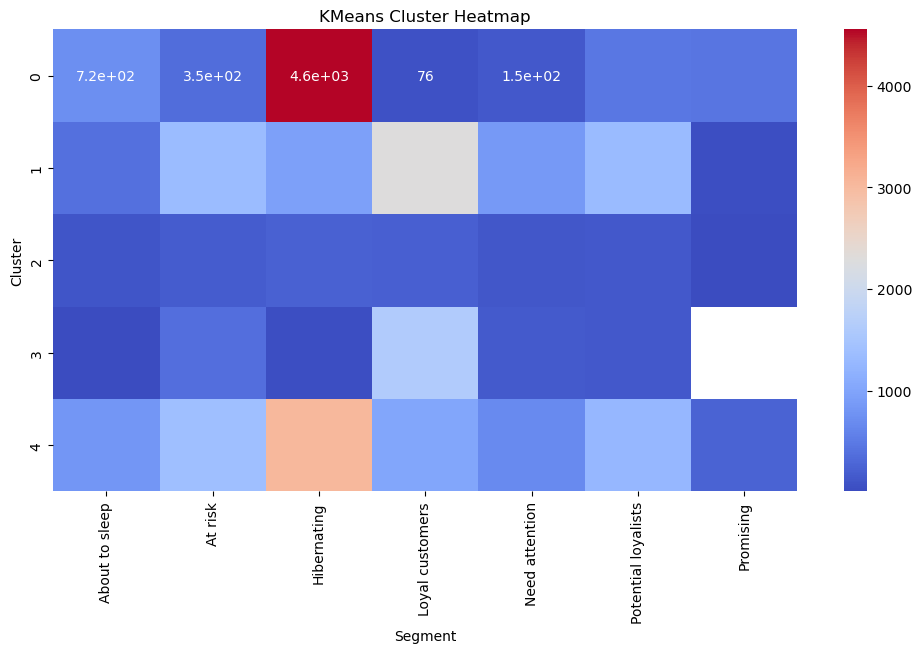

In [184]:
# Plot a cluster heatmap of the Kmeans clusters
plt.figure(figsize=(12, 6))
sns.heatmap(df.groupby(['Cluster', 'Segment']).size().unstack(), annot=True, cmap='coolwarm')
plt.title('KMeans Cluster Heatmap')
plt.show()


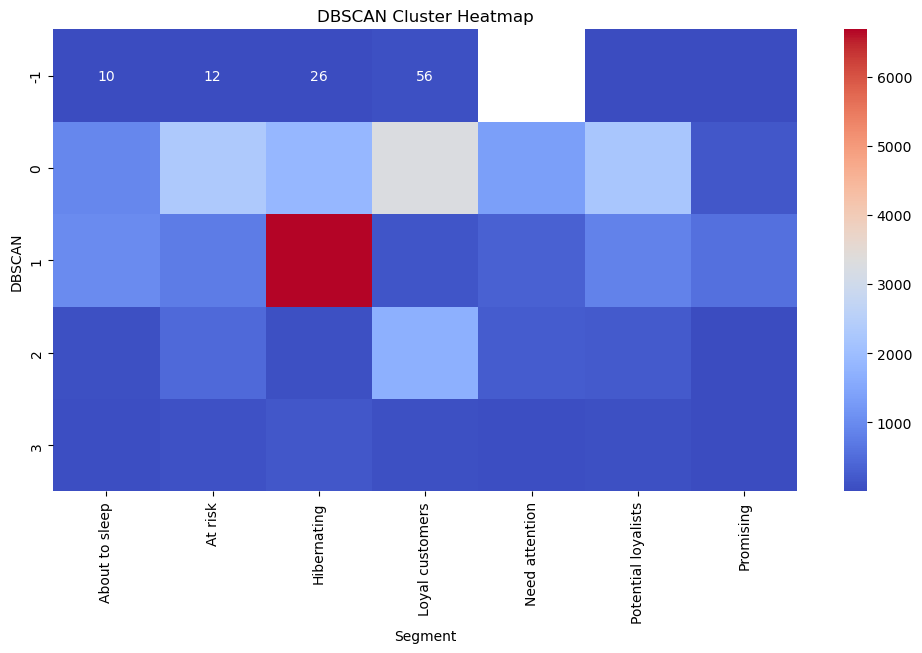

In [146]:
# Plot a cluster heatmap of the DBSCAN clusters
plt.figure(figsize=(12, 6))
sns.heatmap(df.groupby(['DBSCAN', 'Segment']).size().unstack(), annot=True, cmap='coolwarm')
plt.title('DBSCAN Cluster Heatmap')
plt.show()

In [137]:
# Code the Segment column values to numerical values and assign them to a new column called 'Segment_Code'
df['Segment_Code'] = df['Segment'].astype('category').cat.codes
# Print the segment code value counts
print(df['Segment_Code'].value_counts())

Segment_Code
2    8775
3    5208
1    3623
5    3343
0    2053
4    1963
6     762
Name: count, dtype: int64


In [185]:
df

,CUSTOMER_ID,Recency,Frequency,Monetary,POINTS_SPENT,loyalty_score,MODE_REGIONAL_CODE,OUTLET_ID,CATEGORY_ID,Percentage_SPECIAL,...,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score,Segment,Score_Card,Cluster,DBSCAN,CLV
0,AA00312188,24,102,1040,8760,1,11,64,10,0.0,...,2,3,4,234,9,At risk,Silver,1,0,0.041217
1,AA00312390,1,58,687,2240,1,42,91,3,0.0,...,4,2,3,423,9,Potential loyalists,Silver,1,0,0.031630
2,AA00325975,1,205,1386,80675,1,11,7,1,0.0,...,4,4,4,444,12,Loyal customers,Platinum,1,0,0.036424
3,AA00336843,14,69,498,24255,1,11,6,3,0.0,...,2,3,2,232,7,At risk,Bronze,4,0,0.013971
4,AA00339761,23,59,574,4030,1,6,7,10,0.0,...,2,2,3,223,7,Hibernating,Bronze,1,0,0.021706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25722,YZ04556116,173,9,39,0,0,46,114,1,0.0,...,1,1,1,111,3,Hibernating,Green,0,1,0.000657
25723,YZ04586406,9,82,1814,0,0,23,85,3,0.0,...,3,3,4,334,10,Need attention,Gold,0,1,0.155981
25724,YZ04658257,2,116,1029,110880,1,26,35,3,0.0,...,4,4,4,444,12,Loyal customers,Platinum,0,0,0.035480
25725,YZ04743693,25,14,81,0,0,3,113,3,0.0,...,2,1,1,211,4,Hibernating,Green,0,1,0.001822


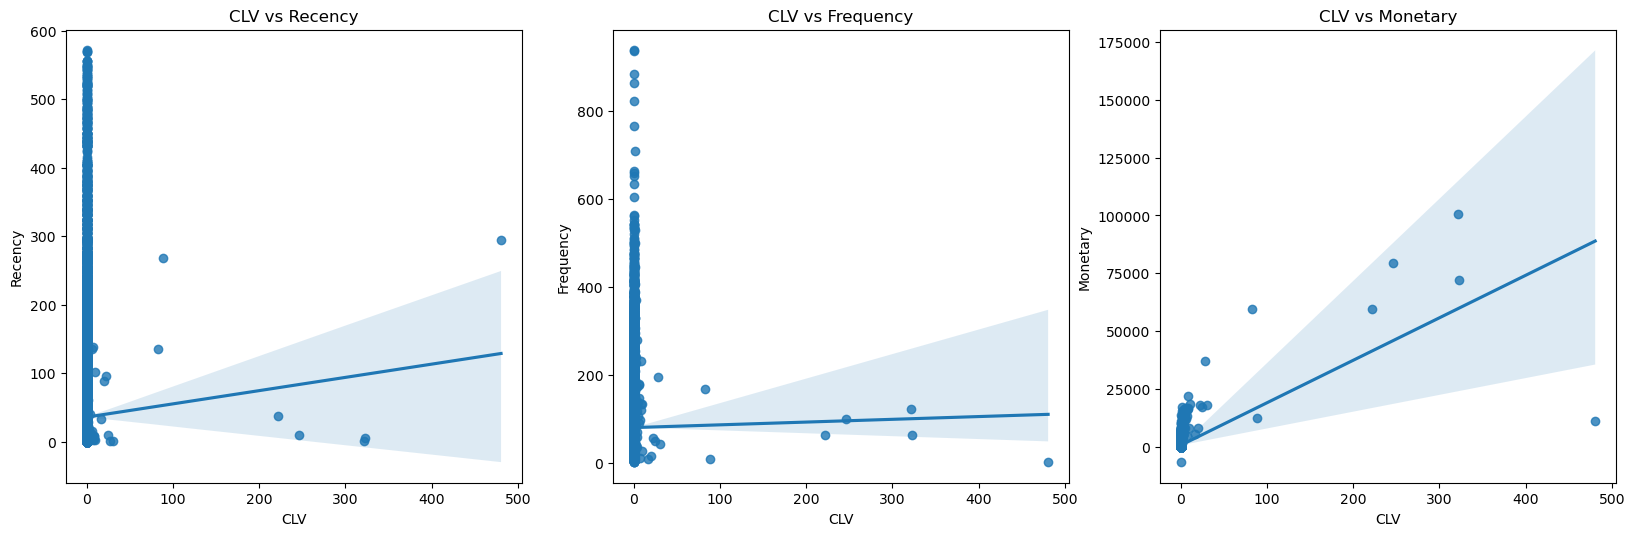

In [191]:
# Plot CLV vs Recency, Frequency and Monetary in subplots
plt.figure(figsize=(20, 20))

# CLV vs Recency
plt.subplot(3, 3, 1)
sns.regplot(x='CLV', y='Recency', data=df)
plt.title('CLV vs Recency')

# CLV vs Frequency
plt.subplot(3, 3, 2)
sns.regplot(x='CLV', y='Frequency', data=df)
plt.title('CLV vs Frequency')

# CLV vs Monetary
plt.subplot(3, 3, 3)
sns.regplot(x='CLV', y='Monetary', data=df)
plt.title('CLV vs Monetary')

plt.show()


In [214]:
# Limits of the CLV column
print('The minimum value of the CLV column is:', df['CLV'].min())
print('The maximum value of the CLV column is:', df['CLV'].max())

The minimum value of the CLV column is: 0.0
The maximum value of the CLV column is: 480.64057216154237


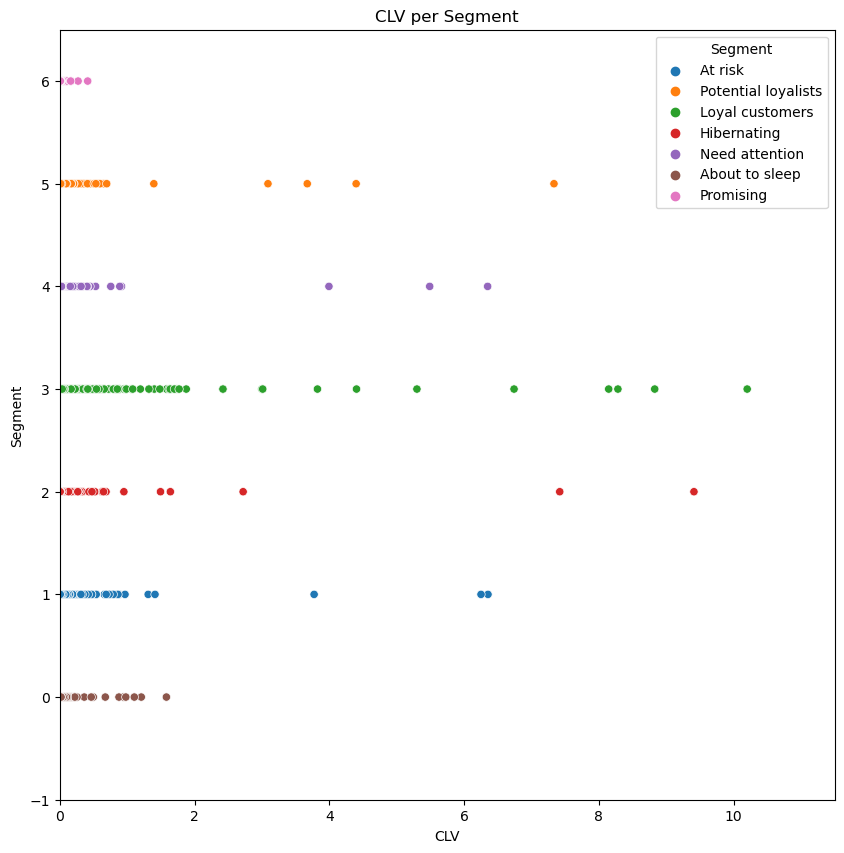

In [213]:
# Convert the Segment column to a numerical value and assign it to a new column called 'Segment_Code'
df['Segment_Code'] = df['Segment'].astype('category').cat.codes

# Plot a scatter plot of CLV and Segment
# Focus the scale to cover 0 to CLV value of 150
plt.figure(figsize=(10, 10))
sns.scatterplot(y='Segment_Code', x='CLV', hue='Segment', data=df)
plt.ylim(-1, 6.5)
plt.xlim(0, 11.5)
plt.xlabel('CLV')
plt.ylabel('Segment')
plt.title('CLV per Segment')
plt.show()